#  Expectation-Maximisation algorithm – Importance sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import random
import pandas as pd
from sklearn.cluster import KMeans

## Exercice 1 : Discrete distributions

### Question 1 

Given that we know how to sample $\mathcal{U}[0,1]$, we can use the inversion method. We introduce the generalized inverse :
$$\begin{align}
F^{-1} : &]0,1[ \to \mathbb{R}\\
& u \to inf\{x \in \mathcal{R} | u \leq F(x)\}
\end{align}$$
We can sample X as $X=F^{-1}(U)$ and $X \sim F$ and $F(X) \sim \mathcal{U}([0,1])$.

### Question 2

In [2]:
def sample_discrete(n,p):
        """ Sample according to a discrete distribution
        Args
        n : number of simulation
        p : vector of probabilities of the discrete distribution
        Output 
        v : vector of samples"""
        u = np.random.uniform(0,1,n)
        p_cum = np.concatenate([[0.0],np.cumsum(p,dtype=float)])
        v = - np.ones(n)
        for i in range(n):
            index = np.max(np.where(p_cum <= u[i])[0])
            v[i] = int(index)
        return v



### Question 3

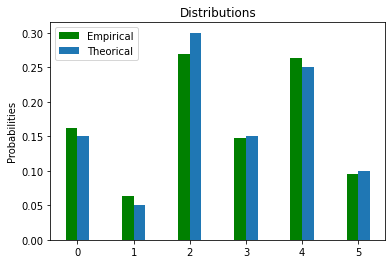

In [3]:
n = 1000
p = np.array([0.15,0.05,0.3,0.15,0.25,0.1])
samples = sample_discrete(n,p)
index = np.linspace(0,len(p),len(p))
hist_samples = [len(np.where(samples==int(i))[0])/n for i in range(len(p))]
ig, ax = plt.subplots()
width = 0.25
ax.bar(index, hist_samples, width, color='g', label='Empirical')
ax.bar(index + width, p, width, label='Theorical')

# add some text for labels, title and axes ticks
ax.set_ylabel('Probabilities')
ax.set_title('Distributions')
ax.set_xticks(index + width / 2)
ax.set_xticklabels((str(i) for i in range(len(p))))
ax.legend()


## Exercice 2: Gaussian mixture model and the EM algorithm

### Question 1

We have $\theta=(\alpha_{1},\alpha_{2},...,\alpha_{m},\mu_{1},...,\mu_{m},\Sigma_{1},...,\Sigma_{m})$, the log likelihood is equal to :
$$\begin{align}
L(x_1, ... x_n;\theta) &= \prod_{i=1}^n f_{\theta}(x_i)\\
&= \prod_{i=1}^n \sum_{j=1}^m f_{\theta}(x_i|z_i=j)p(z_i=j)\\
&= \prod_{i=1}^n \sum_{j=1}^m \alpha_j f_{normal}(x_i, \mu_j, \sigma_j)\\
\end{align}
$$
with $f_{normal}(x_i,\mu_j,\Sigma_j)$ the density function of $\mathcal{N}(\mu_j,\Sigma_j)$.

### Question 2

In [4]:
def sample_MixtureGaus(n, params):
    """ Sample according to a Gaussian mixture model
    Args
    n : number of simulation
    params : alpha, mu and sigma respectively the proportion of each Gaussian, their mean and corariance matrix
    Output
    v : vector of samples
    labels : cluster of the sample"""
    alpha = params['alpha']
    mu = params['mu']
    sigma = params['sigma']
    z = sample_discrete(n, alpha)
    v = np.zeros((n, len(mu[0])))
    indices = [0]
    labels = np.array([])
    for i in range(len(alpha)):
        indices.append(np.sum(z==i))
        v[np.sum(indices[:-1]):np.sum(indices),:] = np.random.multivariate_normal(mu[i], sigma[i], indices[-1])
        labels = np.concatenate((labels, np.repeat(i,indices[-1])))
    return v, labels


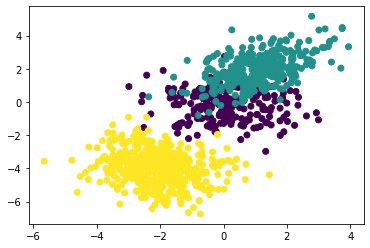

In [5]:
n = 1000
params = {'mu': [np.array([0,0]), np.array([1,2]), np.array([-2,-4])],
          'sigma': [np.identity(2), np.array([[1,0.45],[0.45,1]]), np.array([[1,-0.2],[-0.2,1]])],
          'alpha' : np.array([0.25,0.3,0.45])}


samples, labels = sample_MixtureGaus(n, params)
plt.scatter(samples[:,0],samples[:,1],c=labels)

### Question 3

In [75]:
def loglikelihood(x, params):
    """Compute the log likelihood given the parameters
    Args
    x : dataset
    params : alpha, mu and sigma respectively the proportion of each Gaussian, their mean and corariance matrix
    Output
    log_likelihood : the log likelihood of the observations 
    """
    alpha = params['alpha']
    mu = params['mu']
    sigma = params['sigma']
    likelihood = np.zeros((x.shape[0],len(alpha)))
    for j in range(len(alpha)):
            likelihood[:,j] = alpha[j] * scipy.stats.multivariate_normal.pdf(x, mu[j], sigma[j])
    log_likelihood = np.log(np.sum(likelihood, axis=1))
    return np.sum(log_likelihood)

def e_step(x, params):
    """Computes the e-step of the EM algorithm
    Args
    x : dataset
    params : alpha, mu and sigma respectively the proportion of each Gaussian, their mean and corariance matrix
    Output:
    M : matrix with the probabilities P(z=j|x, tetha)"""
    alpha = params['alpha']
    mu = params['mu']
    sigma = params['sigma']
    M = np.zeros((x.shape[0], len(alpha)))
    for j in range(len(alpha)):
            M[:,j] = alpha[j] * scipy.stats.multivariate_normal.pdf(x, mu[j], sigma[j])
    return M / M.sum(axis=1)[:,np.newaxis]
    
def m_step(x, M, epsilon=1e-5):
    """Compute the m-step of the EM algorithm
    Args
    x : dataset
    M : matrix with the probabilities P(z=j|x, tetha)
    Output
    params : alpha, mu and sigma respectively the proportion of each Gaussian, their mean and corariance matrix"""
    sigma=[]
    mu=[]
    alpha=np.zeros(M.shape[1])
    for j in range(M.shape[1]):
        alpha[j] = np.mean(M[:,j])
        mu.append(np.average(x, axis=0, weights=M[:,j]))
        W=np.identity(x.shape[0])
        np.fill_diagonal(W,M[:,j])
        data_centered=x-mu[j]
        sigma.append((np.transpose(data_centered).dot(W).dot(data_centered))/np.sum(M[:,j])+epsilon*np.argmax(x)*np.eye(x.shape[1]))
    return {'alpha':alpha,'mu':mu,'sigma':sigma}


def EM_algo(x, max_iter=100, k=2, epsilon=1e-5):
    """Aplies the EM algorithm
    Args
    x : dataset
    max_iter : maximum number of iterations
    k : number of clusters
    Outputs
    M : matrix with the probabilities P(z=j|x, tetha)
    params : alpha, mu and sigma respectively the proportion of each Gaussian, their mean and corariance matrix
    log_likelihoods : list of log likelihood through iterations"""

    kmeans = KMeans(n_clusters=k).fit(x)
    labels = kmeans.labels_
    log_likelihoods = []
    params={'mu':[], 'sigma':[], 'alpha':[]}

    for i in range(k):
        indices = np.where(labels==i)[0]
        params['alpha'].append(len(indices)/x.shape[0])
        params['mu'].append(np.average(x[indices,:], axis=0))
        params['sigma'].append(np.cov(x[indices,0],x[indices,1]) + epsilon*np.argmax(x)*np.eye(x.shape[1]))
    log_likelihoods.append(loglikelihood(x, params))

    iter = 0
    while iter < max_iter:
        M = e_step(x, params)
        params = m_step(x, M)
        log_likelihoods.append(loglikelihood(x, params))
        iter = iter + 1
    return M, params, log_likelihoods


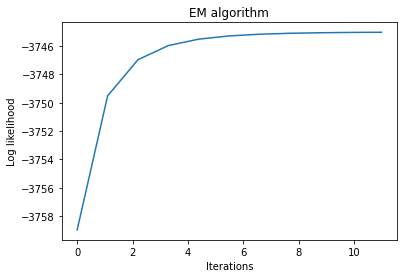

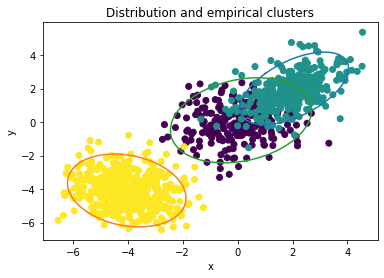

In [76]:
max_iter = 10
params_original = {'mu': [np.array([0,0]), np.array([2,2]), np.array([-4,-4])],
          'sigma': [np.identity(2), np.array([[1,0.45],[0.45,1]]), np.array([[1,-0.2],[-0.2,1]])],
          'alpha' : np.array([0.25,0.3,0.45])}

samples, labels = sample_MixtureGaus(n, params_original)
M, params_estimates, log_likelihoods = EM_algo(samples, max_iter, k=3)
params_estimates['loglike'] = log_likelihoods

plt.plot(np.linspace(0,max_iter +1, max_iter+1),log_likelihoods)
plt.title('EM algorithm')
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

inferred_labels = np.argmax(M, axis=1)
BIC = plot_EM(samples, inferred_labels, params_estimates, labels, k=3)

### Question 4

The empirical results are closed to the original ones, but if the Gaussians of the mixture overlap a lot, it's harder to find the parameters.

In [10]:
for k in params_original.keys():
    print("\nParameter", k)
    print("Theorical", params_original[k])
    print("Empirical", params_estimates[k])


Parameter mu
Theorical [array([0, 0]), array([2, 2]), array([-4, -4])]
Empirical [array([1.92528051, 1.98406438]), array([-3.88638431, -3.95734831]), array([0.10176638, 0.04682775])]

Parameter sigma
Theorical [array([[1., 0.],
       [0., 1.]]), array([[1.  , 0.45],
       [0.45, 1.  ]]), array([[ 1. , -0.2],
       [-0.2,  1. ]])]
Empirical [array([[1.24963529, 0.46360493],
       [0.46360493, 0.89723383]]), array([[ 1.11630482, -0.22063848],
       [-0.22063848,  1.12994761]]), array([[0.99832285, 0.04579349],
       [0.04579349, 1.05677361]])]

Parameter alpha
Theorical [0.25 0.3  0.45]
Empirical [0.29473874 0.4397306  0.26553066]


### Question 5


We can imagine that the birth/death ratio of people coming from the same country follows a Gaussian distribution. It looks like using Gaussian Mixture model would be useful.

Number of countries 440


Text(0.5, 1.0, 'Birth death ratio')

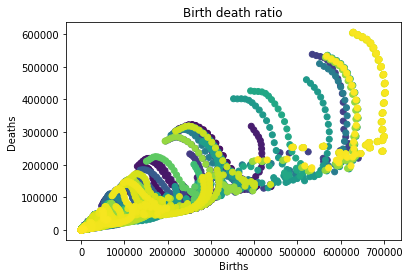

In [16]:
data=np.array(pd.read_csv('/content/WPP2019_Period_Indicators_Medium.csv').dropna())

countries = list(np.unique(data[:,1]))
countries_labels = [countries.index(data[i,1]) for i in range(data.shape[0])]
print("Number of countries", len(countries))

x_birth_death = np.array([data[:,9], data[:,16]], dtype='float64').transpose()
#x_birth_death = x_birth_death / x_birth_death.sum(axis=0)

plt.scatter(x_birth_death [:,0], x_birth_death[:,1], c=countries_labels)
plt.xlabel('Births')
plt.ylabel('Deaths')
plt.title('Birth death ratio')

### Question 6

In [11]:
def plot_EM(x, labels, params, true_labels, k=4, str_=['x', 'y']):
    """Draw the countour of each cluster at 90% and compute BIC
    Args
    x : dataset
    labels : class of the data
    params : alpha, mu and sigma respectively the proportion of each Gaussian, their mean and corariance matrix
    k : number of clusters
    Output
    BIC : BIC criteria """

    f, ax = plt.subplots()
    ax.scatter(x[:,0], x[:,1], c=true_labels)
    s=4.6057
    
    for j in np.arange(0,k):   
        [V, D] = np.linalg.eig(params['sigma'][j] * s)
        t = np.linspace(0, 2*np.pi)
        c = np.array([np.cos(t), np.sin(t)])
        VD = D @ np.sqrt(np.diag(V))
        contour = VD @ c + params['mu'][j].reshape(-1,1)
        ax.plot(contour[0,:], contour[1,:])
    plt.xlabel(str_[0])
    plt.ylabel(str_[1])
    plt.title("Distribution and empirical clusters")
    plt.show()
    
    max_iter = len(params["loglike"])
    df = len(params["alpha"])*(2*2+1)
    BIC = -params["loglike"][max_iter-1] + (df * np.log(x.shape[0])) /2
    return BIC





Number of classes = 3
Estimated parameters {'alpha': array([0.3738269 , 0.53248112, 0.09369197]), 'mu': [array([64316.46953588, 34131.50749961]), array([1808.65525519,  959.58369067]), array([361561.33541705, 220541.08622012])], 'sigma': [array([[3.41941765e+09, 1.22607666e+09],
       [1.22607666e+09, 8.05986665e+08]]), array([[6372079.59727546, 2737257.7577434 ],
       [2737257.7577434 , 1713691.94043257]]), array([[3.42691118e+10, 1.40732239e+10],
       [1.40732239e+10, 1.49021598e+10]])]}


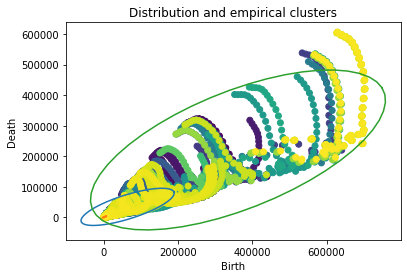

BIC = 283705.3181355051

Number of classes = 5
Estimated parameters {'alpha': array([0.49523803, 0.01248796, 0.34464452, 0.13215178, 0.0154777 ]), 'mu': [array([1373.22436893,  723.28745173]), array([635237.69770507, 464366.0443647 ]), array([40954.58754392, 22247.18399762]), array([206263.39424087, 126684.74282634]), array([574758.98131097, 217538.42914961])], 'sigma': [array([[3203144.4360403 , 1378637.01178571],
       [1378637.01178571,  885985.08048154]]), array([[ 2.37439659e+09, -1.57645771e+08],
       [-1.57645771e+08,  7.78219030e+09]]), array([[1.19908940e+09, 4.45287235e+08],
       [4.45287235e+08, 3.03726023e+08]]), array([[1.04018534e+10, 3.63478768e+09],
       [3.63478768e+09, 5.58958204e+09]]), array([[7.48403882e+09, 3.33777993e+09],
       [3.33777993e+09, 2.15880623e+09]])]}


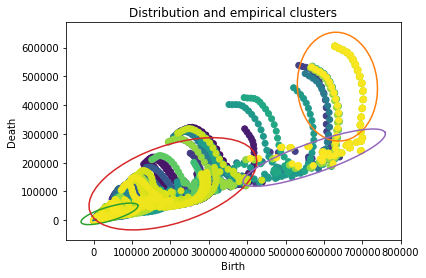

BIC = 280495.24017857155

Number of classes = 10
Estimated parameters {'alpha': array([0.42085049, 0.03755064, 0.01236302, 0.06177736, 0.30479435,
       0.00505482, 0.09921182, 0.01221788, 0.01181335, 0.03436627]), 'mu': [array([815.59665442, 406.78773866]), array([316738.7034561 , 136027.92215819]), array([634599.14282423, 465911.64737394]), array([166163.49425068,  63120.29103891]), array([19497.00220562, 10088.07398571]), array([455760.08131606, 282911.64924102]), array([61711.70301342, 39805.19642997]), array([265803.46675129, 279555.79865139]), array([614364.21258726, 233833.20727906]), array([106495.66009007, 126944.73782622])], 'sigma': [array([[1003900.15032069,  381816.58794468],
       [ 381816.58794468,  210509.67569857]]), array([[4.99248260e+09, 1.26677072e+09],
       [1.26677072e+09, 1.20382877e+09]]), array([[ 2.34689841e+09, -4.77065033e+07],
       [-4.77065033e+07,  7.60493786e+09]]), array([[1.77193388e+09, 2.34397445e+08],
       [2.34397445e+08, 2.81624922e+08]])

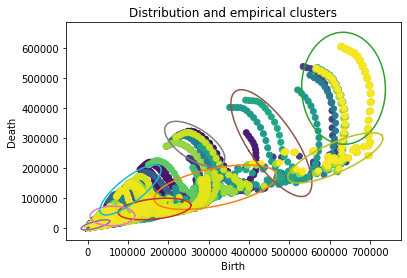

BIC = 275187.1584984886

Number of classes = 25
Estimated parameters {'alpha': array([0.08058394, 0.00592579, 0.01214307, 0.38737077, 0.00226383,
       0.01722677, 0.00848897, 0.00562172, 0.03301274, 0.00802641,
       0.00356961, 0.26079053, 0.00281606, 0.05017181, 0.01926994,
       0.00219124, 0.02638042, 0.00468611, 0.02238739, 0.00659882,
       0.00502618, 0.00221177, 0.00807601, 0.01140923, 0.01375089]), 'mu': [array([45024.52991744, 15315.21788366]), array([606987.43957536, 224359.4517956 ]), array([316522.87219699, 160852.00788662]), array([639.18919147, 322.81014379]), array([694139.99931135, 487296.29672363]), array([154656.40456749,  96235.1358777 ]), array([226775.27302741,  96401.1280745 ]), array([236329.2968755 , 305782.79519955]), array([87261.77578082, 35793.36223136]), array([383259.96196501, 138956.9810241 ]), array([591057.8798258 , 495074.32168597]), array([10250.69060577,  7104.8281283 ]), array([678907.84524847, 264828.74407878]), array([40483.52073516, 38982.0

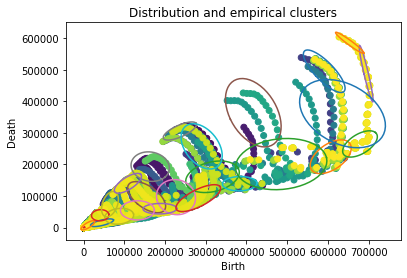

BIC = 272620.30161012977

Number of classes = 50
Estimated parameters {'alpha': array([0.00265215, 0.02750933, 0.00385947, 0.19176041, 0.0022154 ,
       0.01002202, 0.0064434 , 0.0044889 , 0.01746424, 0.00877642,
       0.00117559, 0.00178499, 0.00398107, 0.00099445, 0.03500509,
       0.00183837, 0.00150123, 0.01325653, 0.00420714, 0.01775851,
       0.00434329, 0.00233954, 0.01036816, 0.0067766 , 0.00299639,
       0.00722165, 0.32318761, 0.04000594, 0.01879027, 0.00156554,
       0.00137251, 0.00444798, 0.03885979, 0.00166533, 0.00117077,
       0.0068219 , 0.01105195, 0.0040422 , 0.00758878, 0.00480515,
       0.00293474, 0.00104369, 0.00099767, 0.00178316, 0.01323371,
       0.01310786, 0.00460037, 0.09994359, 0.00572003, 0.00051912]), 'mu': [array([680549.27045815, 263875.91849198]), array([36498.72079147, 40832.25540407]), array([234718.91639233, 119842.3508585 ]), array([3422.06842924, 1893.46049899]), array([578882.9727506 , 514328.01613099]), array([119637.95951954,  55260.4

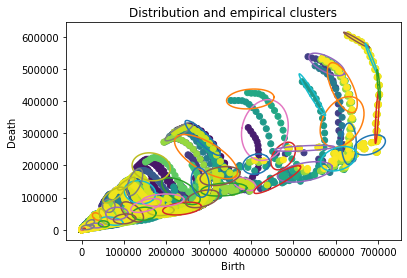

BIC = 268971.2805593086

Number of classes = 100
Estimated parameters {'alpha': array([0.28452428, 0.00185279, 0.00411412, 0.00086929, 0.01880614,
       0.00425949, 0.00244217, 0.00199014, 0.0026911 , 0.00805472,
       0.00086553, 0.00479878, 0.02622397, 0.00087157, 0.00129839,
       0.00071965, 0.00687244, 0.00161588, 0.00131596, 0.00192812,
       0.00366804, 0.01083672, 0.00315466, 0.00134682, 0.00620938,
       0.02121086, 0.00411779, 0.00072778, 0.00206772, 0.00428945,
       0.00397807, 0.00030097, 0.00897188, 0.00198081, 0.00149301,
       0.00168726, 0.00088491, 0.0015366 , 0.00193109, 0.0004496 ,
       0.00192278, 0.00151071, 0.01723126, 0.00045147, 0.02248738,
       0.00070431, 0.00158628, 0.00206511, 0.17478244, 0.00145542,
       0.01301388, 0.00095423, 0.00353391, 0.01001524, 0.00464183,
       0.00132243, 0.03531769, 0.00112685, 0.0022027 , 0.00460772,
       0.00660658, 0.00282319, 0.0020438 , 0.00089127, 0.00090216,
       0.00570854, 0.0021919 , 0.00081464, 0.0059

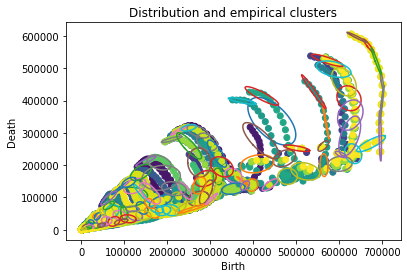

BIC = 268257.94757141947

Number of classes = 250


KeyboardInterrupt: ignored

In [17]:
K = [3, 5, 10, 25, 50, 100, 250]

for i in K:
    print("\nNumber of classes =", i)
    M, params_estimates, log_likelihoods = EM_algo(x_birth_death, max_iter, k=i)
    print("Estimated parameters", params_estimates)
    params_estimates['loglike'] = log_likelihoods
    inferred_labels = np.argmax(M, axis=1)
    BIC = plot_EM(x_birth_death, inferred_labels, params_estimates, countries_labels, k=i, str_=['Birth', 'Death'])
    print("BIC =", BIC)


The BIC decreases when we increase the number of classes, however the result becomes chaotic and unreadable. Moreover, the classes formed do not correspond to the theoretical classes. Visually, about 10 classes seems the best choice. 

## Exercice 3 : Importance sampling

###Question 1:

In [86]:
def f(x):
    """Computes the value of f"""
    if x>0:
        f = 2*np.sin(np.pi/1.5*x)
    else:
        f = 0
    return f

def p(x):
    """Computes density p"""
    if x>0:
        p = x**(0.65)*np.exp(-x**2/2.)
    else:
        p = 0
    return p

def q(x, mu, sigma):
    """Computes density q"""
    q = (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(x-mu)**2/(2*sigma**2))
    return q

def importance_sampling(N,mu,sigma):
    """Importance sampling procedure
    Args
    N : number of samples
    mu : mean
    sigma : variance
    Output
    samples : vector sampled with importance procedure"""
    samples = []
    w = []
    while len(samples) < N:
      sim = np.random.normal(loc=mu, scale=sigma**2)
      if sim > 0:
        w = p(sim)/q(sim, mu, sigma)
        samples.append(f(sim)*w)
    return np.mean(samples)

###Question 2:

N =  10
Mean value 0.7558933701468935
N =  100
Mean value 0.7597418500245138
N =  1000
Mean value 0.7580100807676609
N =  10000
Mean value 0.7592182879680308


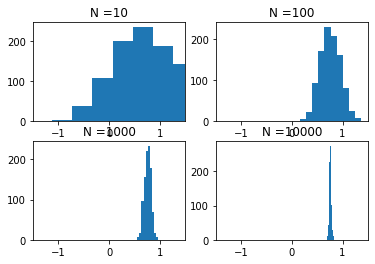

In [100]:
samples_N = {10:[], 100:[], 1000:[], 10000:[]}

i=0
for k in samples_N.keys():
    plt.subplot(2, 2, i+1)
    i+=1
    for j in range(1000):
        samples_N[k].append(importance_sampling(k,0.8,1.5))
    plt.hist(samples_N[k])
    plt.xlim(-1.5,1.5)
    plt.title('N ='+str(k))
    print("N = ", k)
    print("Mean value", np.mean(samples_N[k]))

plt.show()



The larger the sample size, the more the results are condensed around the mean.

###Question 3:

N =  10
Mean value 20.94978532623005
N =  100
Mean value 19.97345280103729
N =  1000
Mean value 21.2330028681072
N =  10000
Mean value 21.153871374107528


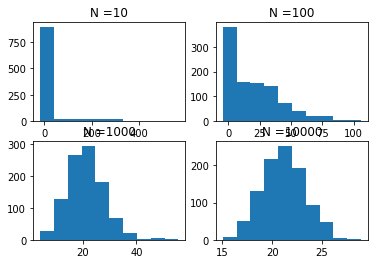

In [104]:
samples_N = {10:[], 100:[], 1000:[], 10000:[]}

i=0
for k in samples_N.keys():
    plt.subplot(2, 2, i+1)
    i+=1
    for j in range(1000):
        samples_N[k].append(importance_sampling(k,6.0,1.5))
    plt.hist(samples_N[k])
    plt.title('N ='+str(k))
    print("N = ", k)
    print("Mean value", np.mean(samples_N[k]))

plt.show()


The error caused by this change in mean is large and is not corrected even when using many samples.